# <font color=blue> Score: 93/100 </font>
## <font color=blue> Comments: </font>
- <font color=blue> The project implmented the pricing formulas in Heston model and conduceted calibration the Heston model to market data in `python`.   
- The project is well written, well organized, and the codes are well structured. There were not much left to comment on. 
- For more detailed comments (if any) on the content/code/presentation, see the inserted cells, the text will be in blue.

# NSD Final Project

## Title: Volatility smile generation using calibrated Heston model

### Team member: 刘晓冰 王艺纯 杨谨行

# Abstract

In the Black-Scholes world, the volatility is assumed constant. But in reality, options of different strike require different volatilities to match their market prices. This is called the *volatility smile*. In this project, to better demonstrate the shape of volatility,  we take a closer look at a stochastic volatility model discussed in class -- the Heston model. We first calibrate the Heston model by the latest real market data. Then, applying the Fast Fourier Transform method, we use the calibrated model and the Black-Scholes model to calculate option prices separately. Next, we leverage the Rooting and Minimize Object Function methods to compute the implied volatilities and visualize them accordingly. Our verification shows that compared with the Black-Scholes model, the Heston model can indeed show the shape of the volatility more accurately. 

# Table of content
[1. Introduction](#sec1)

[2. Option Pricing](#sec2)
- [2.1 Models](#sec2.1)
    - [2.1.1 Black-Scholes (BS) model for Call/Put Pricing](#sec2.1.1)
    - [2.1.2 Heston Model for Call/Put Pricing](#sec2.1.2)
- [2.2 Methods](#sec2.2)
    - [2.2.1 FFT Method](#sec2.2.1)
- [2.3 Define BS_pricer and Heston_pricer Class](#sec2.3)
    - [2.3.1 BS_pricer](#sec2.3.1)
    - [2.3.2 Heston_pricer](#sec2.3.2)

[3. Model Calibration with Market Data](#sec3) 

[4. Principle of implied Volatility](#sec4)
- [4.1 Rooting Method](#sec4.1)
- [4.2 Minimize Object Function Method](#sec4.2)
- [4.3 Comparison](#sec4.3)

[5. Generating volatility smile using Heston](#sec5)
- [5.1 Two types of Heston model](#sec5.1)
- [5.2 Generating volatility smile](#sec5.2)

[6. Conclusion and Discussions](#sec6)

# 1. Introduction <a id='sec1'></a>

The Black-Scholes model for option pricing was introduced in 1970 and served as one of the first models for helping investors derive a price associated with an option on a security. In general, it helped to promote option investing as it created a model for analyzing the price of options on various securities. The main limitation of the Black-Scholes model is to hold volatility constant. One way to handle the problem and to model our market in a more realistic way is to use stochastic volatility models. The assumption that volatility is arbitrary, rather than constant, is the key factor that makes stochastic volatility models unique. Heston Model, one of the most famous stochastic volatility models, is developed by associate finance professor Steven Heston in 1993. With great interest in these two models, we review and study some relevant literature, attempting to compare these two models by their reduction degree of the volatility smile, a common graph shape that results from plotting the strike price and implied volatility of a group of options with the same underlying asset and expiration date. And through reviewing literatures, we notice that the feller conditon on the Heston model should not be used as a constraint. In many cases its violation will be required for a good fit to the market data. So, we also want to use market data to verify.
<br><br>
When to implement the Heston model, we refer to Wim Schoutens, Erwin Simons and Jurgen Tistaert's working paper named 'A Perfect Calibration! Now What?', using real data to calibrate the model. For option pricing, we find that much of the recent literatures on option valuation have successfully applied Fourier analysis to determine option prices. Unfortunately, this approach is unable to harness the considerable computational power of the fast Fourier transform (FFT), which represents one of the most fundamental advances in scientific computing. After getting the data of option written on the SPY ETF, we use the Rooting and Minimize object function methods to compute the volatility.

<font color=blue>Though it should not stop you from trying/exploring other numerical methods, the (simple) bisection method for numeically calculating the volatility from option prices works pretty efficiently, to my knowledge.  </font>

### Market Data:
We choose a dataset of S&P([SPY](https://en.wikipedia.org/wiki/SPDR_S%26P_500_Trust_ETF)) 500 option prices from [barchart](https://www.barchart.com/etfs-funds/quotes/SPY/options?moneyness=allRows&expiration=2020-08-14-w), a website that provided real-time financial data.

The current date is 07 Aug 2020. The maturity date is 14 Aug 2020. $ \quad \quad \sim$ 1 week time to maturity.
    
If we assume 252 business days, the time to maturity to the 7th of Aug corresponds to the year fraction 
$T = 5/252$, where 8 and 9 Aug are holidays.     

The current value of SPY is $S_0 = 334.33$.    

##### Comment:
For very short times to maturity ($\sim$ days), it is very difficult to replicate the smile in the *in-the-money* and *out-of-the-money* regions. There are several reasons. There can be numerical error issues in the pricing and in the calibration process. Or more simply, the chosen stochastic model is not well-fitted.
<br>
<font color=blue>Nice observation, it is more likely the case that stochastic volatility models don't fit because of the limitations in diffusion type of models. </font>

### Notation:

We define the following notations (parameters) for the option in market data:

- $S_0$ = Current stock price
- $K$ = Strike price
- $T$ = Time to maturity
- $v_0$ = (optional) spot variance 
- $r$ = Risk free constant rate
- $\mu$ = Constant drift 
- $\rho$ = Correlation between stock noise and variance noise
- $\theta$ = Long term mean of the variance process
- $\sigma$ = Volatility coefficient of the variance process 
- $\kappa$ = Mean reversion coefficient for the variance process

### Packages used in this project:

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# For calculation and solvinge quations/optimazation
import scipy.stats as ss
import scipy.optimize as scpo
from scipy import sparse
from scipy.fftpack import ifft
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from functools import partial

# Result Presenting
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import warnings; warnings.filterwarnings("ignore")

# 2. Option Pricing <a id='sec2'></a>

## 2.1 Models <a id='sec2.1'></a>

### 2.1.1 Black-Scholes (BS) Model for Call/Put Pricing <a id='sec2.1.1'></a>

Under the Black-Scholes (BS) model, the best method to price a European option is to use the [BS formula](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model).

The **BS formula** for a call is:

$$ C(t,T,S_t,K,r,\sigma) = S_t N(d_1) - K e^{-r(T-t)} N(d_2) $$

with 

$$ d_1 = \frac{1}{\sigma \sqrt{T-t}} \biggl[ \log \biggl( \frac{S_t}{K} \biggr) + \biggl(r + \frac{\sigma^2}{2} \biggr) (T-t) \biggr] \quad \mbox{and} \quad d_2 = d_1 - \sigma \sqrt{T-t} $$

where $N$ is the cumulative distribution function of a standard normal random variable.    
<font color=blue>The above BS formula holds if the underlying pays no dividend. When applied to real data, dividend rate has to be taken into account.</font>


In this case, the value of an option can be also computed as the discounted expectation of a future payoff in this way:

$$\begin{aligned}
 C(S_t,K,T) &= e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\biggl[ (S_T - K)^+ \bigg| S_t \biggr] \\
            &= e^{-r(T-t)} \int_0^{\infty} (S_T - K)^+ f(S_T|S_t) dS_T    \\
            &= e^{-r(T-t)} \int_K^{\infty} (S_T - K) f(S_T|S_t) dS_T 
\end{aligned}$$

where $f(S_T|S_t)$ is the risk neutral transition probability of the process $\{S_u\}_{u\in [t,T]}$. 

And the log-normal density function is

$$ f(S_T|S_t) = \frac{1}{S_T \sigma \sqrt{2\pi (T-t)}} \; e^{- \frac{ \biggl[\log(S_T) - \bigl(\log(S_t) + (r-\frac{1}{2} \sigma^2)(T-t) \bigr) \biggr]^2}{2\sigma^2 (T-t)}} $$

In [2]:
# Class of the diffusion process that stores parameters of BS Model
class Diffusion_process():    
    def __init__(self, r=0.1, sig=0.2, mu=0.1):
        """    
        r: risk free interest rate(constant)
        sig: constant diffusion coefficient(positive)
        mu: constant drift coefficient
        """
        self.r, self.mu, self.sig = r, mu, sig

### 2.1.2 Heston Model for Call/Put Pricing <a id='sec2.1.2'></a>

The Heston process is described by the <font color=blue> system of </font> SDE<font color=blue>s</font>: 

$$ \begin{cases}
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t 
\end{cases}$$

The stock price follows a "geometric Brownian motion" with a stochastic volatility. The square of the volatility (the variance) follows a CIR process.     

The parameters are:
- $\mu$ drift of the stock process
- $\kappa$ mean reversion coefficient of the variance process
- $\theta$ long term mean of the variance process 
- $\sigma$  volatility coefficient of the variance process
- $\rho$ correlation between $W^1$ and $W^2$ i.e.
$$ dW^1_t dW^2_t = \rho dt $$

If the parameters obey the following condition $2\kappa \theta > \sigma^2$(known as the *Feller condition*) then the process $v_t$ is strictly positive. We will discuss the necessity of this condition when indroducing the market data context in [5.1 Two types of Heston model](#sec5.1).

In [3]:
# Class of the Heston process that stores the parameters
class Heston_process():
    def __init__(self, mu=0.1, rho=0, sigma=0.2, theta=-0.1, kappa=0.1):
        """
        r: risk free constant rate
        rho: correlation between stock noise and variance noise (|rho| must be <=1)
        theta: long term mean of the variance process(positive)
        sigma: volatility coefficient(positive)
        kappa: mean reversion coefficient for the variance process(positive)
        """
        self.mu, self.rho, self.theta, self.sigma, self.kappa = mu, rho, theta, sigma, kappa           

## 2.2 Methods <a id='sec2.2'></a>

There are several ways to calculate the option price such as *Lewis method*, *Fourier-inversion method*, etc. However, when we want to compute the price of a large number of options with the same maturity, the previous methods are no more efficient. A solution is to take advantage of the FFT (Fast Fourier Transform) algorithm to reduce the computational cost. <br><br>
Our technique assumes that the characteristic function of the risk-neutral density is known analytically. Given any such characteristic function, we develop a simple analytic expression for the Fourier transform of the option value or its time value. We then use the FFT to numerically solve for the option price or its time value.

### 2.2.1 FFT Method <a id='sec2.2.1'></a>

Recall that the *real part* of a complex number is linear, i.e. for $a,b\in \mathbb{R}$ we have $Re[a z_1 + b z_2] = a Re[z_1] + b Re[z_2]$, and the real part of an integral is the integral of the real part.    
Thanks to this property, the integral pricing formula can be written in the following form:

$$ C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} Re \biggl[ \int_{0}^{\infty} e^{iuk} \phi_T \bigg(u-\frac{i}{2} \bigg) \frac{1}{u^2 + \frac{1}{4}} du \biggr]. $$

At this point we can discretize the integral. we use the [Simpson rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) to deal with it.     
The domain of integration is truncated in $[A,B] = [0,B]$, and divided in $N$ steps of size $\Delta x = \frac{B}{N}$.
We have that $x_0 = 0$ and $x_n = x_0 + n \Delta x$, for $n=0,1,2,...,N$. The integral is evaluated in $N+1$ points $f(x_n) = f_n$.     
The Simpson rule is a 3 points rule that approximates the integral as:

$$ \int_{x_0}^{x_2} f(x) \, dx \approx \frac{\Delta x}{3} \big[ f_0 + 4 f_1 + f_2 \big]. $$

if we sum over the integration domain $[x_0, x_{N-1}]$ we get

$$ \int_{x_0}^{x_{N-1}} f(x) \, dx \approx \frac{\Delta x}{3} \sum_{n=0}^{N-1} w_n \, f_n. $$

with $w_n=1$ for $n=0$ and $n=N-1$, and $w_n=4$ for $n$ odd, and $w_n=2$ for $n$ even. Notice that we are not considering the last point!

Define a set of $N$ values $k_j \in [-b,b]$, such that $k_j = -b + j \Delta k$, for $j=0,1,2,...,N-1$. We define the step $\Delta k$ as 

$$ \Delta k := \frac{2 \pi}{B} = \frac{1}{\Delta x} \frac{2 \pi}{N} $$       

such that we can obtain the value $b=\frac{N \Delta k}{2}$.    
The integral in the pricing function is:

$$ 
\begin{aligned}
I(k_k) &= \int_{0}^{\infty} e^{ixk_j} \phi_T \bigg(x-\frac{i}{2} \bigg) \frac{1}{x^2 + \frac{1}{4}} dx 
\quad \approx \quad \frac{\Delta x}{3} \sum_{n=0}^{N-1} w_n \, e^{ik_j x_n} \phi_T \bigg( x_n-\frac{i}{2} \bigg) \frac{1}{{x_n}^2 + \frac{1}{4}} \\
&= \frac{\Delta x}{3} \sum_{n=0}^{N-1} w_n \, e^{i (-b + j \Delta k) n \Delta x} \phi_T \bigg( x_n-\frac{i}{2} \bigg) \frac{1}{{x_n}^2 + \frac{1}{4}}. \\
&= \frac{\Delta x}{3} \sum_{n=0}^{N-1} \, e^{i 2\pi j \frac{n}{N}} \; w_n e^{-i b n \Delta x} \phi_T \bigg( x_n-\frac{i}{2} \bigg) \frac{1}{{x_n}^2 + \frac{1}{4}}.
\end{aligned}$$
  
#### Note
The [scipy function ifft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.ifft.html#scipy.fftpack.ifft) returns: `y(j) = (x * exp(2*pi*sqrt(-1)*j*np.arange(n)/n)).mean()` So we need to multiply the return by N.

In [4]:
def fft(K, S0, r, T, cf): # interp support cubic 
    """ 
    K = vector of strike
    S0 = spot price scalar
    cf = characteristic function
    """
    N=2**15                         # FFT more efficient for N power of 2
    B = 500                         # integration limit 
    
    dx = B/N
    x = np.arange(N) * dx

    weight = 3 + (-1)**(np.arange(N)+1) # Simpson weights
    weight[0] = 1; weight[N-1]=1

    dk = 2*np.pi/B
    b = N * dk /2
    ks = -b + dk * np.arange(N)

    integrand = np.exp(- 1j * b * np.arange(N)*dx) * cf(x - 0.5j) * 1/(x**2 + 0.25) * weight * dx/3
    integral_value = np.real( ifft(integrand)*N )
    spline_cub = interp1d(ks, integral_value, kind="cubic") # cubic will fit better than linear
    prices = S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_cub( np.log(S0/K) )
    
    return prices

## 2.3 Define Black-Scholes and Heston pricing model <a id='sec2.3'></a>

In [5]:
# A class that stores option parameters (in order to write BS/Heston class neatly)
class Option_param():  
    def __init__(self, S0=100, K=100, T=1, v0=0.04, payoff="call", exercise="European"):
        """
        S0: current stock price
        K: Strike price
        T: time to maturity
        v0: (optional) spot variance 
        exercise: European or American
        """
        self.S0, self.v0, self.K, self.T, self.exercise, self.payoff = S0, v0, K, T, exercise, payoff

### 2.3.1 Black-Scholes pricing model <a id='sec2.3.1'></a>

At this point, we are able to build a BS pricer class with methods discussed above.

In [6]:
class BS_pricer():
    """
    Finite-difference Black-Scholes PDE = df/dt + r df/dx + 1/2 sigma^2 d^f/dx^2 -rf = 0
    """
    def __init__(self, Option_info, Process_info ):
        """
        Process_info: a instance of "Diffusion_process.", which contains (r,mu, sig) 
        Option_info: of type Option_param, which contains (S0,K,T)
        """ 
        self.r = Process_info.r           # interest rate
        self.sig = Process_info.sig       # diffusion coefficient
        self.S0 = Option_info.S0          # current price
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity in years
        
        self.price = 0
        self.S_vec = None
        self.price_vec = None
        self.mesh = None
        self.exercise, self.payoff = Option_info.exercise, Option_info.payoff
        
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
        
    @staticmethod # Black Scholes closed formula
    def BlackScholes(payoff='call', S0=100., K=100., T=1., r=0.1, sigma=0.2 ):
        d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S0/K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        if payoff=="call":
            return S0 * ss.norm.cdf( d1 ) - K * np.exp(-r * T) * ss.norm.cdf( d2 )
        elif payoff=="put":
            return K * np.exp(-r * T) * ss.norm.cdf( -d2 ) - S0 * ss.norm.cdf( -d1 )
    
    # FFT method that yields a vector of prices.
    def FFT(self, K): # K: an array of strikes
        
        # Characteristic function of a Normal random variable
        def cf_normal(u, mu=1, sig=2):
            return np.exp( 1j * u * mu - 0.5 * u**2 * sig**2 )
        
        K = np.array(K)
        cf_GBM = partial(cf_normal, mu=( self.r - 0.5 * self.sig**2 )*self.T, sig=self.sig*np.sqrt(self.T))  # function binding
        if self.payoff == "call":
            return fft(K, self.S0, self.r, self.T, cf_GBM)
        elif self.payoff == "put":    # put-call parity
            return fft(K, self.S0, self.r, self.T, cf_GBM) - self.S0 + K*np.exp(-self.r*self.T)

### 2.3.2 Heston pricing model <a id='sec2.3.2'></a>

In [7]:
# Class to price the options with the Heston model by:
class Heston_pricer():
    
    def __init__(self, Option_info, Process_info ):
        """
        Process_info: a instance of "Heston_process.", which contains (mu, rho, sigma, theta, kappa)
        Option_info: of type Option_param, which contains (S0,K,T)
        """
        self.r = Process_info.mu              # interest rate
        self.sigma = Process_info.sigma       # Heston parameters
        self.theta = Process_info.theta       
        self.kappa = Process_info.kappa       
        self.rho = Process_info.rho           
        
        self.S0 = Option_info.S0          # current price
        self.v0 = Option_info.v0          # spot variance
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity(in years)
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
    
    # payoff function
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
    
    # FFT method. It returns a vector of prices.
    def FFT(self, K): # K: strikes
        K = np.array(K)
        
        # Heston characteristic function (proposed by Schoutens 2004)
        def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
            xi = kappa - sigma*rho*u*1j
            d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
            g1 = (xi+d)/(xi-d)
            g2 = 1/g1
            cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
                      + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
            return cf
        
        cf_H_b_good = partial(cf_Heston_good, t=self.T, v0=self.v0, mu=self.r, theta=self.theta, 
                                  sigma=self.sigma, kappa=self.kappa, rho=self.rho)
        if self.payoff == "call":
            return fft(K, self.S0, self.r, self.T, cf_H_b_good)
        elif self.payoff == "put":        # put-call parity
            return fft(K, self.S0, self.r, self.T, cf_H_b_good) - self.S0 + K*np.exp(-self.r*self.T)

# 3. Model Calibration with <font color=blue>(grammar: to)</font> Market Data <a id='sec3'></a>

Several advanced equity option models incorporating stochastic volatility can be calibrated very nicely to a realistic option surface. In order to accurately compute the following parameters in the Heston model, we use the market data mentioned in the section above to calibrate.
    
   - $r$ = Risk free constant rate
   - $\rho$ = Correlation between stock noise and variance noise
   - $\theta$ = Long term mean of the variance process
   - $\kappa$ = Mean reversion coefficient for the variance process
   - $\sigma$ = Volatility coefficient of the variance process

In [8]:
data = pd.read_csv("./data/spy-options-exp-2020-08-14-weekly-show-all-stacked-08-07-2020.csv")
data

,Strike,Last,% From Last,Bid,Midpoint,Ask,Change,%Chg,IV,Volume,Open Int,Type
0,160,0.00,-0.5214,174.31,174.48,174.65,0.00,unch,1.9417,0,0,Call
1,165,0.00,-0.5065,169.31,169.48,169.65,0.00,unch,1.8636,0,0,Call
2,170,0.00,-0.4915,164.30,164.48,164.65,0.00,unch,1.7783,0,0,Call
3,175,0.00,-0.4766,159.31,159.48,159.65,0.00,unch,1.7143,0,0,Call
4,180,0.00,-0.4616,154.30,154.48,154.65,0.00,unch,1.6338,0,0,Call
...,...,...,...,...,...,...,...,...,...,...,...,...
233,375,0.00,0.1216,40.36,40.53,40.69,0.00,unch,0.1035,0,0,Put
234,380,0.00,0.1366,45.37,45.53,45.68,0.00,unch,0.0000,0,0,Put
235,385,59.23,0.1516,50.36,50.53,50.69,59.23,unch,0.0000,4,1,Put
236,390,0.00,0.1665,55.36,55.52,55.68,0.00,unch,0.0000,0,0,Put


In [9]:
data = data.loc[:,['Strike', 'Bid', 'Midpoint', 'Ask',  'Type']]
data["Spread"] = (data.Ask - data.Bid)
data

,Strike,Bid,Midpoint,Ask,Type,Spread
0,160,174.31,174.48,174.65,Call,0.34
1,165,169.31,169.48,169.65,Call,0.34
2,170,164.30,164.48,164.65,Call,0.35
3,175,159.31,159.48,159.65,Call,0.34
4,180,154.30,154.48,154.65,Call,0.35
...,...,...,...,...,...,...
233,375,40.36,40.53,40.69,Put,0.33
234,380,45.37,45.53,45.68,Put,0.31
235,385,50.36,50.53,50.69,Put,0.33
236,390,55.36,55.52,55.68,Put,0.32


## 3.1 Principle of Calibration

If we call $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:

$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$

where $P_i$ are the market prices, $f$ is the pricing function and $w_i$ are weights usually defined as 

$$ w_i = \frac{1}{\text{spread}_i} $$


Among the many numerical methods, here we use the following modules:
- [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
- [minimize(method=’SLSQP’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp)

For the unconstrained Heston problem we use `curve_fit`, while for the constrained Heston problem we use `minimize`.

##### Comment:
In order to make the code simpler, we will only use CALL prices for the calibration.

In [10]:
CALL = data[data.Type=="Call"]
# PUT = data[data.Type=="Put"].reset_index(drop=True)
prices = CALL.Midpoint.values
strikes = CALL.Strike.values
spreads = CALL.Spread.values
payoff = "call"

## 3.2 Heston parameters calibration

What to do with the **Feller condition**?

The Feller condition is hardly satisfied in the market, mainly because having $\kappa \theta > \frac{1}{2} \sigma^2$ implies a high mean reversion which reduces the volatility of the stochastic volatility $\sigma^2$. The vol is responsible for the convexity of the smile. In order to increase the convexity to match the empirical smile, we have to increase $\sigma^2$ violating the Feller condition. However this is not really an issue, at the moment the $v_t$ reaches $0$ we have a positive drift $dv_t = \kappa \theta dt$ that will push instantly the process away from 0.


Let us calibrate the two cases:
- Ignoring the Feller condition (using `curve_fit`).
- Introducing the Feller condition as an inequality constraint (using `minimize`).


#### Comment:
1. The calibration of the Heston pricing model is a difficult task and here we just choose a very naive approach.

2. The calibration of 5 parameters will make the following code **quite slow**. 



In [11]:
def report_calibration(initial_guess, calibrated_params):
    report = pd.DataFrame({"Initial guess": initial_guess, "Calibrated": calibrated_params},
                          index=["rho", "sigma", "theta", "kappa", "v0"]).round(4).T
    return report

### 3.2.1 Unconstrained problem
> Heston model that ignore feller condition

In [12]:
S0=334.33; K=S0; T=5/252; r=0.05
    # option price at Augest 7
    
# Objective function
def f_Hest(x, rho, sigma, theta, kappa, v0, r=0.05):
    Heston_param = Heston_process(mu=r, rho=rho, sigma=sigma, theta=theta, kappa=kappa)
    opt_param = Option_param(S0=S0, K=K, T=T, v0=v0, exercise="European", payoff=payoff )
    Hest = Heston_pricer(opt_param, Heston_param)
    return Hest.FFT(x)

init_vals = [-0.6, 1.0, 0.04, 2.5, 0.04] # rho, sigma, theta, kappa, v0
bounds = ( [-1, 1e-15, 1e-15, 1e-15, 1e-15], [1, np.inf, 2, np.inf, 2] )
params_Hest = scpo.curve_fit(f_Hest, strikes, prices, 
                             p0=init_vals, bounds=bounds, sigma=spreads,
                             xtol=1e-4, max_nfev=1000)[0]

# Result
report_calibration(init_vals, params_Hest)

,rho,sigma,theta,kappa,v0
Initial guess,-0.6000,1.0000,0.0400,2.5000,0.0400
Calibrated,-0.5292,3.0542,0.4019,8.3793,0.0002


In [13]:
# check the Feller condition
# 2*kappa*theta - sigma^2
2*8.1152*0.416 - 3.056**2

-2.5872896

### 3.2.2 Constrained problem
> Take feller condition into account

In [14]:
def Feller(x):
    return 2*x[3] * x[2] - x[1]**2 - 1e-6
cons = ({"fun": Feller, "type": "ineq"})

def least_sq(x, prices, strikes, spread):
    """ Objective function """
    Heston_param = Heston_process(mu=r, rho=x[0], sigma=x[1], theta=x[2], kappa=x[3])
    opt_param = Option_param(S0=S0, K=K, T=T, v0=x[4], exercise="European", payoff="call" )
    Hest = Heston_pricer(opt_param, Heston_param)
    prices_calib = Hest.FFT(strikes)
    return np.sum( ((prices_calib - prices)/spread)**2 ) 

init_vals = [-0.4, 1.1, 0.1, 0.6, 0.02] # rho, sigma, theta, kappa, v0
bounds = ( (-1,1), (1e-15,np.inf), (1e-15, 50), (1e-15, 50), (1e-15, 10) )
params_Hest_con = scpo.minimize(least_sq, x0=init_vals, args=(prices, strikes, spreads),
                  method='SLSQP', bounds=bounds,
                  constraints=cons, tol=1e-4, options={"maxiter":500}).x

# Result
report_calibration(init_vals, params_Hest_con)

,rho,sigma,theta,kappa,v0
Initial guess,-0.4000,1.1000,0.1000,0.6000,0.020
Calibrated,-0.4587,1.4455,0.8294,0.5845,0.027


In [15]:
# check the Feller condition
# 2*kappa*theta - sigma^2
2*0.5845*0.8294 - 1.4455**2

-1.11990165

# 4. Principle of implied Volatility <a id='sec4'></a>

We choose Rooting and Minimize Object Function these two methods to compute the implied volatility. It is worth noting that since we calibrate the Heston model using real market data, in the next process of calculation, we use the BS formula and the option price given by the Heston model to solve volatility.

## 4.1 Rooting Method <a id='sec4.1'></a>

How to find the value $\sigma$ such that  

$$ BS\;(S, K, T, r, \sigma) - P = 0 $$
for fixed $S, K, T, r$.

In the function below we use 
[fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html),
which is a very efficient method, as the default method, but with the possibility to switch to the brent method.

### Notes

Since $\sigma$ is constant, we directly get an option price from traditional BS model (the so-called closed-form BS formula, which is the one we learned in class). While here, $\sigma$ is the independent variable and option price is the dependent variable, which means $ BS\;(S, K, T, r, \sigma) $ is a function of $\sigma$: $ P= BS\;(\sigma) $.We need to find $P$ and solve the equation. 

In [16]:
# Returns Implied volatility using fsolve
def implied_volatility( price, S0, K, T, r, payoff="call", disp=True ):

    def obj_fun(vol):
        return ( price - BS.BlackScholes(payoff=payoff, S0=S0, K=K, T=T, r=r, sigma=vol) )

    X0 = [0.19, 0.21, 0.5, 1, 2, 3]   # set of initial guess points
    for x0 in X0:
        x, _, solved, _ = scpo.fsolve( obj_fun, x0, full_output=1, xtol=1e-14)
        if solved == 1:
            return x[0]  

    if disp == True:
        print("Strike", K)
    return -1

## 4.2 Minimize Object Function Method <a id='sec4.2'></a>

Another approach is to find

$$ \text{argmin}_{\theta} \bigg( BS\;(S, K, T, r, \sigma) - P \bigg)^{2n}  \quad \quad \text{for } n>0$$

It is useful when the root finder is not able to find a solution.

### Note <a id='Note'></a>

When Considering BS model, $P$ has two choices:
- One is market data (the way we get the solution of $\sigma$ called "BS-inversion")
- The other is BS model using FFT method (ignoring several exception values, the solution tends to be around the setting $\sigma=0.2$).

When considering Heston model, $P$ also has two choices:
- One is Heston with Feller condition
- The other is Heston without Feller condition.

We will plot them all in the following text.

In [17]:
# Returns Implied volatility by minimization
def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BS.BlackScholes(payoff=payoff, S0=S0, K=K, T=T, r=r, sigma=vol) - price )**n
        
    res = scpo.minimize_scalar( obj_fun, bounds=(1e-14, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1

## 4.3 Comparison

Now, we can used the built functions and classes to compute the implied volatilities by two different equation solving methods (from [4.1](#sec4.1) and [4.2](#sec4.2)).

In [18]:
# Set parameters
opt_param = Option_param(S0=S0, K=K, T=T, v0=0.04, exercise="European", payoff="call" )
diff_param = Diffusion_process(r=0.05, sig=0.2)
Heston_param = Heston_process(mu=0.1, rho=-0.3, sigma=0.6, theta=0.04, kappa=5)

# Build the pricers
BS = BS_pricer(opt_param, diff_param)
Hest = Heston_pricer(opt_param, Heston_param)

# Compute the price
BS_prices = BS.FFT(strikes)
Hest_prices = Hest.FFT(strikes)
strikes = CALL.Strike.values

#### In BS:

,K,BS_prices,IV_BS,IV_BS_min
0,160,1.744887e+02,0.829381,0.829382
1,165,1.694936e+02,0.782137,0.782136
2,170,1.644986e+02,0.747976,0.747977
3,175,1.595035e+02,0.734645,0.734644
4,180,1.545085e+02,0.695991,0.695991
...,...,...,...,...
114,375,6.001508e-05,0.200056,0.200056
115,380,6.703539e-06,0.200084,0.200083
116,385,6.317804e-07,0.200124,0.200124
117,390,5.118306e-08,0.200254,0.200254


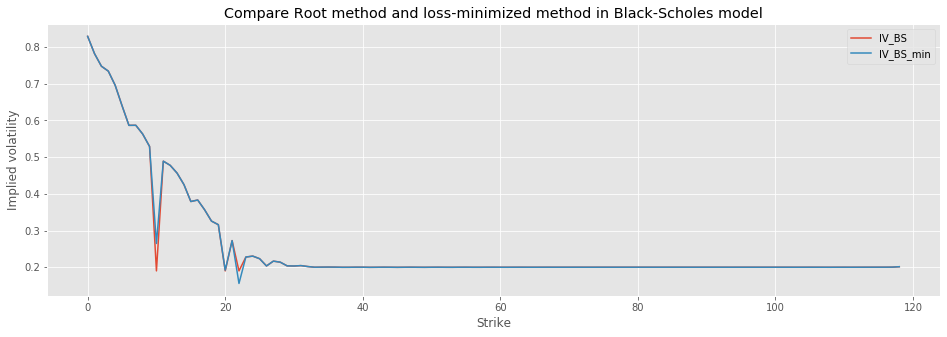

In [19]:
BS_compare = pd.DataFrame({"K": strikes, "BS_prices": BS_prices})
BS_compare["IV_BS"] = BS_compare.apply(lambda x: implied_volatility(x["BS_prices"], S0, K=x["K"], T=T, r=r), axis=1)
BS_compare["IV_BS_min"] = BS_compare.apply(lambda x: implied_vol_minimize(x["BS_prices"], S0, K=x["K"], T=T, r=r), axis=1)

ax = BS_compare[["IV_BS","IV_BS_min"]].plot(figsize=(16,5), title = "Compare Root method and loss-minimized method in Black-Scholes model")
ax.set_xlabel("Strike")
ax.set_ylabel("Implied volatility")
BS_compare

From the graph above, we can see that the solution is around the setting $\sigma=0.2$, which verifies the note from [Note](#Note).

#### In Heston:

Strike 359.0


,K,Hest_prices,IV_Hest,IV_Hest_min
0,160,1.746471e+02,2.134010,2.134009
1,165,1.696571e+02,2.058911,2.058911
2,170,1.646670e+02,1.985550,1.985550
3,175,1.596769e+02,1.913821,1.913821
4,180,1.546868e+02,1.843626,1.843625
...,...,...,...,...
114,375,4.512824e-05,0.197121,0.197120
115,380,5.765623e-06,0.198790,0.198791
116,385,6.799187e-07,0.200660,0.200660
117,390,7.566950e-08,0.202723,0.202724


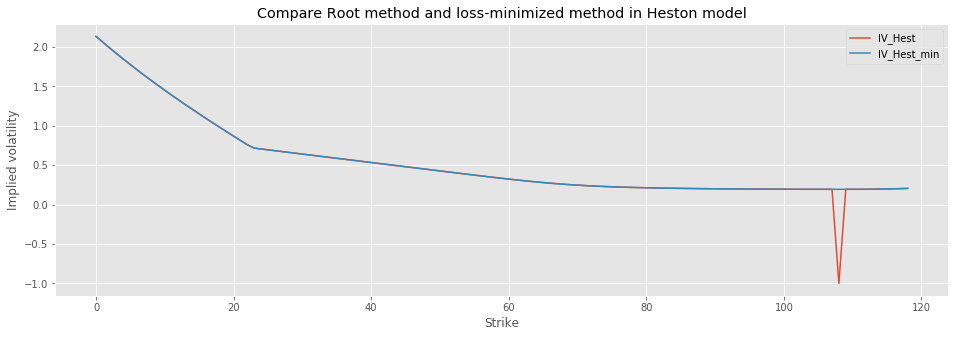

In [20]:
Hest_compare = pd.DataFrame({"K": strikes, "Hest_prices": Hest_prices})
Hest_compare["IV_Hest"] = Hest_compare.apply(lambda x: implied_volatility(x["Hest_prices"], S0, K=x["K"], T=T, r=r), axis=1)
Hest_compare["IV_Hest_min"] = Hest_compare.apply(lambda x: implied_vol_minimize(x["Hest_prices"], S0, K=x["K"], T=T, r=r), axis=1)

ax = Hest_compare[["IV_Hest","IV_Hest_min"]].plot(figsize=(16,5), title = "Compare Root method and loss-minimized method in Heston model")
ax.set_xlabel("Strike")
ax.set_ylabel("Implied volatility")
Hest_compare

From the data above, we found that $\sigma$ calculated by `implied_volatility` is deeply depend on the market data and the initial guess points. For some points, the calculation does not act well, though changing market data or initial guess points leads to a more accurate result. While for the other points, using the two methods to calculate $\sigma$ is almost equal. Therefore, we choose the robust function: `implied_vol_minimize` to calculate $\sigma$ in our project.

After finishing the compution of $\sigma$, we then deal with some inconsistent values.

In [21]:
CALL["IV_mid"] = CALL.apply(lambda x: implied_vol_minimize(x['Midpoint'], S0, x['Strike'], T, r, payoff="call"), axis=1)
CALL = CALL.loc[CALL.IV_mid != -1,:].reset_index(drop=True) 
# When there is no implied volatility able to reproduce the mid-price, the function returns -1, we ignore these data points.
CALL

,Strike,Bid,Midpoint,Ask,Type,Spread,IV_mid
0,160,174.31,174.48,174.65,Call,0.34,0.432070
1,165,169.31,169.48,169.65,Call,0.34,0.421505
2,170,164.30,164.48,164.65,Call,0.35,0.415187
3,175,159.31,159.48,159.65,Call,0.34,0.557729
4,180,154.30,154.48,154.65,Call,0.35,0.425453
...,...,...,...,...,...,...,...
114,375,0.00,0.01,0.01,Call,0.01,0.286070
115,380,0.00,0.01,0.01,Call,0.01,0.315879
116,385,0.00,0.01,0.01,Call,0.01,0.345028
117,390,0.00,0.01,0.01,Call,0.01,0.373567


# 5. Generating volatility smile using Heston

## 5.1 Two types of Heston model <a id='sec5'></a>
> With and without feller condition constrained

In [22]:
# Constrained(with feller condition)
opt_param_Feller = Option_param(S0=S0, K=K, T=T, v0=params_Hest_con[4], exercise="European", payoff=payoff )
Heston_param_Feller = Heston_process(mu=r, rho=params_Hest_con[0], sigma=params_Hest_con[1], theta=params_Hest_con[2], kappa=params_Hest_con[3])
Hest_Feller = Heston_pricer(opt_param_Feller, Heston_param_Feller)
Hest_Feller_pred = Hest_Feller.FFT(strikes)

# Unconstrained:
opt_param = Option_param(S0=S0, K=K, T=T, v0=params_Hest[4], exercise="European", payoff=payoff )
Heston_param = Heston_process(mu=r, rho=params_Hest[0], sigma=params_Hest[1], theta=params_Hest[2], kappa=params_Hest[3])
Hest = Heston_pricer(opt_param, Heston_param)
Hest_pred = Hest.FFT(strikes)

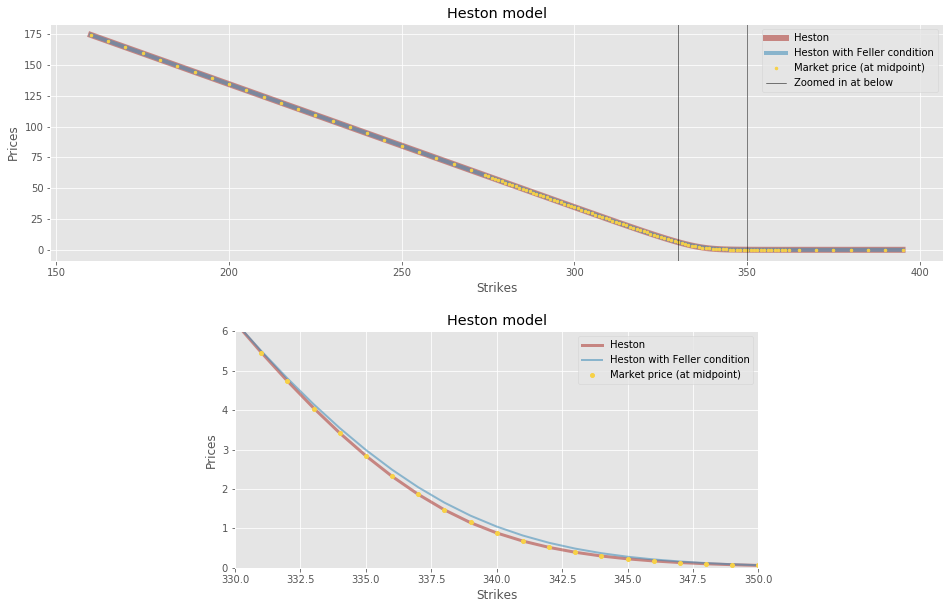

In [23]:
# Plot prices gained from Heston with and without feller condition

grid = plt.GridSpec(2, 5, hspace=0.3)
fig = plt.figure(figsize=(16,10))
# Full plot
ax1 = plt.subplot(grid[0,:])
ax1.plot(strikes, Hest_pred, label="Heston", color='#ab312a88', linewidth=6)
ax1.plot(strikes, Hest_Feller_pred, label="Heston with Feller condition", linewidth=4, color='#3a89b788')
ax1.plot(strikes, prices, 'o', label="Market price (at midpoint)",  color='#f7d147', ms=2.5)
ax1.axvline(330, color="black", label="Zoomed in at below", linewidth=0.5)
ax1.axvline(350, color="black", linewidth=0.5)
ax1.set_title("Heston model")
ax1.set_xlabel("Strikes")
ax1.set_ylabel("Prices")
ax1.legend()

# Zoomed-in plot
ax2 = plt.subplot(grid[1,1:-1])
ax2.plot(strikes, Hest_pred, label="Heston", color='#ab312a88', linewidth=3)
ax2.plot(strikes, Hest_Feller_pred, label="Heston with Feller condition", linewidth=2, color='#3a89b788')
ax2.plot(strikes, prices, 'o', label="Market price (at midpoint)",  color='#f7d147', ms=4)
ax2.set_title("Heston model")
ax2.set_xlabel("Strikes")
ax2.set_ylabel("Prices")
ax2.axis([330,350,0,6])
ax2.legend()

plt.show()

In [24]:
# Noted that the FFT method has problems for deep OTM values and short maturities. We manually replace the negative values with fake 0
Hest_Feller_pred[Hest_Feller_pred<0] = 1e-8

,Mean Absolute (Pricing) Error
Heston,0.0325
Heston with Feller.,0.0581


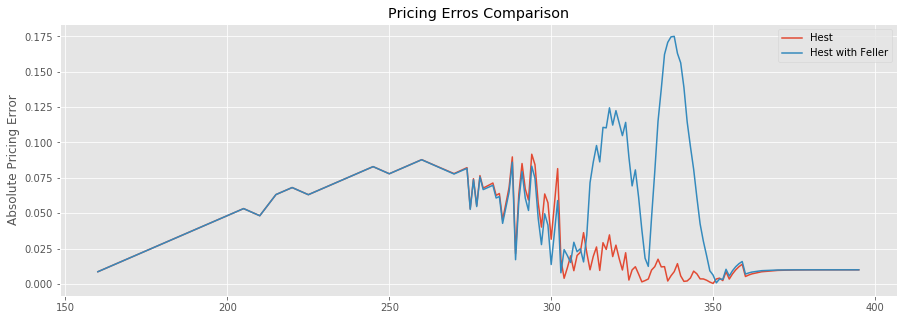

In [25]:
# Compare the errors of the used pricing models:
fig, ax = plt.subplots(figsize=(15,5))
#ax.plot(strikes, spreads, label="True", linewidth=2, color="red") # Get the origin price in the same plot!
ax.plot(strikes, np.abs( prices - Hest_pred ), label="Hest")
ax.plot(strikes, np.abs( prices - Hest_Feller_pred ), label="Hest with Feller")
ax.set_title("Pricing Erros Comparison"); ax.set_ylabel("Absolute Pricing Error"); ax.legend()

pd.DataFrame({
    "Heston": np.abs( prices - Hest_pred ).mean(),
    "Heston with Feller.": np.abs( prices - Hest_Feller_pred ).mean()
},index=["Mean Absolute (Pricing) Error"]).round(4).T

From the above figure, we could find that the price calculated by the Heston model is very accurate and close to the market price. At the same time, there is no big difference in calculating the price with or without the feller condition. But in smaller intervals, the performance of Heston model without the feller condition is better than the other. Next, let's look at the impact on the calculation of volatility.

## 5.2 Generating volatility smile

In [26]:
# From Heston
IV_Hest = [implied_vol_minimize( Hest_pred[i], S0=S0, K=K, T=T, r=r) for i,K in enumerate(strikes)]
IV_Hest_F = [implied_vol_minimize( Hest_Feller_pred[i], S0=S0, K=K, T=T, r=r) for i,K in enumerate(strikes)]

# From market
payoff = "call"
prices = CALL.Midpoint.values
strikes = CALL.Strike.values
spreads = CALL.Spread.values

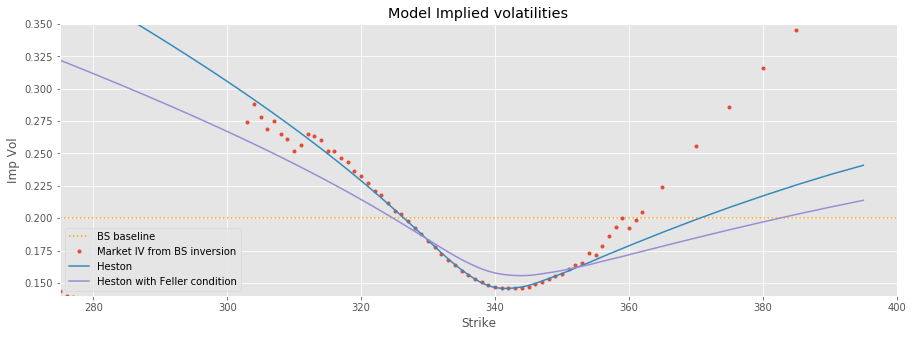

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(y=0.2,ls=":",c="orange", label="BS baseline")
ax.plot(strikes, CALL.IV_mid, '.', label="Market IV from BS inversion")
ax.plot(strikes, IV_Hest, label="Heston")
ax.plot(strikes, IV_Hest_F, label="Heston with Feller condition")
ax.axis([275,400,0.14,0.35]);
ax.set_title("Model Implied volatilities")
ax.set_ylabel("Imp Vol")
ax.set_xlabel("Strike")
ax.legend()

#plt.show()
plt.savefig('./image/result.png', dpi=500)

From the picture above, we could first find that Heston model can reflect the real world volatility more accurately  than BS model. From the perspective of implied volatilities, we can also discover that, Heston model without the feller condition perfomances closer to the market value, since the feller condition is a sufficient condition, but not necessary for positivity and often violated.

# 6. Conclusion and Discussions <a id='sec6'></a>

As for the two methods -- Rooting method and Minimize Object Function method, we find that the calculated implied volatility is highly related to data and the initial values. And to some extent, using the two methods to calculate $\sigma$ is almost equal. Therefore, we choose a more robust method: Minimize object function method to calculate $\sigma$ in our project. 

For the two types of Heston models, one is with Feller condition, the other is without Feller condition. In the pricing aspect and smaller intervals, the performance of Heston model without Feller condition is better than the other. Besides, if we consider the perspective of implied volatility, we also notice that the Heston model without Feller has a better reduction of the real situation.

In general, Heston model is indeed more advantageous than the classic BS model in showing the real smile curve because of its more reasonable assumptions.

Our project have some weaknesses that can be honed in the future due to the limit of time and energy. First, the calibration of Heston parameters will make the code quite slow, we could refer to some papers to improve it. Second, we only use a relatively simple data to verify our points. If time permits, we could expand the dataset to more options and to diversified maturities. <font color=blue> I am not sure if it really worth the effort because the Heston model doesn't fit either. </font>

The whole project may not be perfect, but we really enjoy the process of working together to dig into our interest points and to complete this teamwork. We sincerely thank the professor and the teaching assistant for your help and guidance during this course, we have all learned and gained a lot. 

# Reference

[1] Martin Schmelze (2010), Option Pricing Formulae using Fourier Transform: Theory and Application. 

[2] N.G. Shephard (1991), "From characteristic function to distribution function, a simple framework for the theory", Econometric Theory, 7, 519-529.

[3] Carr, P. and D. Madan (1999). "Option valuation using the fast Fourier transform",
Journal of Computational Finance 2(4), 61–73.

[4] Lewis, A. (2001) "A Simple Option Formula for General Jump-Diffusion and other Exponential Lévy Processes", Envision Financial Systems and OptionCity.net, California.

[5] Gil-Pelaez, J. (1951) "Note on the inversion theorem", Biometrika 38(3–4), 481–482.

[6] Steven L. Heston.A Closed-Form Solution for Options with Stochastic Volatilitiy with Applications to Bond and Currency Options[J].The Review of Financial Studies,1993,6(2):327-343.

[7] Wim Schoutens, Erwin Simons, Jurgen Tistaert.A Perfect Calibration! Now What?[J].Wilmott,2004,2:66-78.

[8] Yiran Cui, Sebastian del Baño Rollin, Guido Germano, (2017), "Full and fast calibration of the Heston stochastic volatility model" European Journal of operational research.